<img src="https://github.com/sobester/ADRpy/raw/master/docs/ADRpy/ADRpy_splash.png" width="40%" align="left">

*Given a general layout (perhaps one of several candidates at this stage) and some idea of the maximum take-off weight, the next major step of the conceptual design process is the constraint analysis, which will yield the required wing area and thrust - effectively giving 'scale' to the concept.*

*The constraint analysis establishes the boundaries of the feasible part of the thrust to weight ratio (T/W) versus wing loading (W/S) space. Each element of the mission of the aircraft 'bites out' a chunk from this space and the aeroplane we progress to the subsequent stages of the design process will have to 'live' in the remaining subspace - generally at the lowest thrust/smallest wing point of the remaining feasible chunk.*

*This notebook is designed to walk the reader through ADRpy's constraint analysis capabilities in the context of an example, that of a single piston engine, propeller driven aircraft.*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ADRpy import unitconversions as co
from ADRpy import constraintanalysis as ca
from ADRpy import atmospheres as at

# Example - Constraint Analysis of the Cirrus SR22

The Cirrus SR22 is a single engine, piston driven propeller aircraft.
To analyse a concept aircraft based on the SR22, we extract performance data from [[1]](#refs) and [[2]](#refs).

## Defining the Aircraft Concept

*For brevity, some user-definable parameters have been omitted - but a full list of parameters is available in the class documentation for `AircraftConcept`.*

We begin by creating a dictionary variable containing elements of the design brief.

Each row refers to a specific constraint: take-off, turn, climb, cruise, service ceiling, and stall.
All constraints are given for the clean configuration (no flaps/slats) apart from the take-off constraint.


In [2]:
# Extracted from [1]
nturn = 1 / np.cos(np.radians(60))  # Approx. load factor for 60 degrees of bank

designbrief = {
    "rwyelevation_m": 0.0, "groundrun_m": co.feet2m(1_082),           # Take-off
    "turnalt_m": 0, "turnspeed_ktas": 100, "stloadfactor": nturn,     # Sustained turn
    "climbalt_m": 0, "climbspeed_kias": 108, 'climbrate_fpm': 1_251,  # Climb
    "cruisealt_m": co.feet2m(10e3), "cruisespeed_ktas": 174,          # Cruise
    "servceil_m": co.feet2m(17_500), "secclimbspd_kias": 95,          # Service Ceiling
    "vstallclean_kcas": 73                                            # Stall
}

Next, we describe the aircraft concept itself.
Geometry definitions are given at a very high level, along with an initial estimate for aircraft maximum take-off weight (MTOW).

Not all constraints of the aircraft have to be satisfied at MTOW, in which case we can also specify `"weightfractions"` for any of `"take-off"`, `"turn"`, `"climb"`, `"cruise"`, and `"servceil"` (service ceiling).

In [3]:
# Extracted from [2]
designdefinition = {
    "aspectratio": 10.12, "taperratio": 0.5,    # Wing "slenderness"
    "weight_n": co.lbf2n(3400),                 # Weight estimate
    "weightfractions": {"cruise": 3400 / 3600}  # Weight fractions
}

Now we define some performance estimates.
In some cases, users will have to estimate values from historical precedent of similar class or type aircraft.

In this case, the performance parameters are readily available from [[2]](#refs).

In [4]:
# Extracted from [2]
designperformance = {
    "CDmin": 0.02541, "CLmax": 1.41, "CLminD": 0.20, "CL0": 0.0,  # General performance
    "mu_R": 0.04, "CLTO": 0.590, "CDTO": 0.0414, "CLmaxTO": 1.69  # Take-off specific performance
}

All of the constraints have been defined under ISA standard day conditions.
For this reason, we initialise an object of the `Atmosphere` class to enable our constraint analysis.

In [5]:
designatm = at.Atmosphere()

And finally, to inform the constraint methods of how to normalise thrust and/or power estimates to sea-level static, it is necessary to specify the type of propulsion system.

In [6]:
designpropulsion = "Piston"

Having defined each of the aircraft concept's design brief,  definition, performance, atmopshere, and propulsion system attributes, we are ready to build our `AircraftConcept`:

In [7]:
concept = ca.AircraftConcept(
    brief=designbrief,
    design=designdefinition,
    performance=designperformance,
    atmosphere=designatm,
    propulsion=designpropulsion
)

## Plotting a Constraint Diagram

### Default Visualisation

Here is how to get a quick, clean result:
1. Define a monotonic range of wing loadings (in Pascal).
2. Call the `AircraftConcept.plot_constraints` method.

Depending on the concept's design attributes, the design space will be presented with any of the following
- x-axis: Wing area or Wing loading
- y-axis: Thrust/Weight, Thrust, Power/Weight, or Power

The plotting method intelligently recognises that a propeller based propulsion system would rather present to the user a metric related to power (as opposed to thrust), and since a MTOW was specified, P/W is automatically 'dimensionalised' as the required shaftpower.

See below...

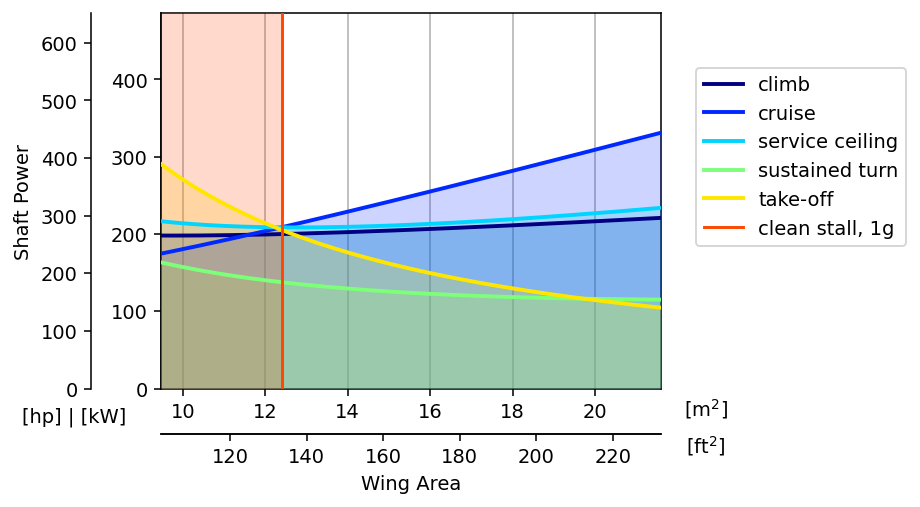

In [8]:
# Create a figure that shows off the constraints
ws_pa = np.arange(700, 1600, 5)         # Step 1
_, _ = concept.plot_constraints(ws_pa)  # Step 2

The unshaded region indicates the feasible design space.

### Customising the Default Plot

We can further constrict the design space by applying a limit to the available shaftpower.
At the conceptual stage this may come from a general idea of the spread of power ratings across aircraft of similar types, or the known availability in a number of *off-the-shelf* solutions from engine manufacturers.
In this case we know for example, that the Cirrus SR22 uses a *Teledyne Continental IO-550-N*, rated for 310 horsepower.

In [9]:
ratedpower_w = co.hp2w(310)

Since we have the `fig` and `ax` objects of the constraint diagram, we can modify them to include this limitation.
It's worth noting that the `ax` object is always constructed with SI base units such as `[N]`, `[m/s]`, `[%]`, `[Pa]`, or `[W]`, and so you must make any modifications to the plot using these same unit scales.

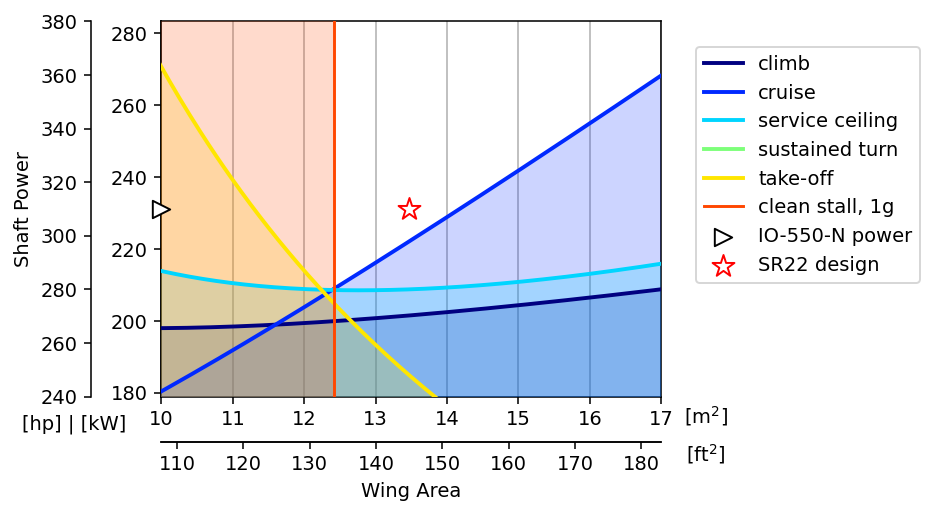

In [10]:
fig, ax = concept.plot_constraints(ws_pa)  # Make a fresh plot

# Optionally: Zoom in so we can see the constraint up close
# Do this now, otherwise our use of clip_on=False will cause markers to plot incorrectly later
ax.set_xlim(10, 17)
ax.set_ylim(co.hp2w(240), co.hp2w(380))

xaxis_limit_l, _ = ax.get_xlim()   # Left (and right) values of the plot's x-axis limits
designarea_m2 = co.feet22m2(145)  # We happen to know the design wing area of the SR22

# Using clip_on=False lets us put markers anywhere in the figure, including outside the plot area
common = {"fc": "white", "clip_on": False, "zorder": 100}
ax.scatter(xaxis_limit_l, ratedpower_w, marker=">", ec="k", s=80, label="IO-550-N power", **common)
ax.scatter(designarea_m2, ratedpower_w, marker="*", ec="r", s=140, label="SR22 design", **common)

ax.remake_legend();  # Refresh the legend with this custom method

Note that, as expected, the actual aircraft (the Cirrus SR-22) falls into the bottom corner of the feasible (unshaded) region.
Also rather interestingly, the constraint curves appear to converge around a minimum feasible shaftpower of ~280 hp.
The 'G' variant of the IO-550 is rated for 280 horsepower.

### A more flexible approach

The method demonstrated above creates a quick constraint diagram, but what if the engineer wishes to present the constraints in a different way, or perhaps, add additional constraints (e.g. constraints computed at different altitudes, weights, etc.)?

The solution is to 'unwrap' the constraint calculations:

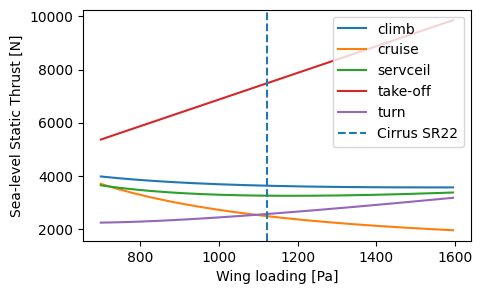

In [11]:
# Desired functions:labels to constrain
constraintfunctions = {
    "climb": concept.constrain_climb,
    "cruise": concept.constrain_cruise,
    "servceil": concept.constrain_servceil,
    "take-off": concept.constrain_takeoff,
    "turn": concept.constrain_turn
}

# Create plot data
tw_reqs, pw_reqs = dict(), dict()

for label, func in constraintfunctions.items():
    tw_reqs[label], pw_reqs[label] = func(ws_pa)

# Plot!
fig, ax = plt.subplots(figsize=(5, 3))

for name, tw in tw_reqs.items():
    ax.plot(ws_pa, tw * concept.design.weight_n, label=name)

concept_ws = concept.design.weight_n / designarea_m2
ax.axvline(concept_ws, ls="--", label="Cirrus SR22")

ax.set_xlabel("Wing loading [Pa]")
ax.set_ylabel("Sea-level Static Thrust [N]")
ax.legend();

# References
<a id="refs"></a>

[1] "Pilot's Operating Handbook and FAA Approved Airplane Flight Manual for the Cirrus SR22," Cirrus Design, 2013. Accessed: 25/12/2023. [Online]. Available: http://servicecenters.cirrusdesign.com/tech_pubs/SR2X/pdf/POH/SR22-004/pdf/Online13772-004.pdf.

[2]  Gudmundsson, S., "General Aviation Aircraft Design: Applied Methods and Procedures", Butterworth-Heinemann, 2013. 